In [5]:
import mxnet as mx
import os
import multiprocessing
num_cpus = multiprocessing.cpu_count()

from pycuda import driver 
driver.init()
num_gpus = driver.Device.count()
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]

print("Number of CPUs:", num_cpus)
print("Number of GPUs:", num_gpus)

Number of CPUs: 16
Number of GPUs: 4


In [6]:
import gluonnlp as nlp
from mxnet.contrib import amp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm
import io
from importlib import reload

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams
import transformer_model

# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(100)

## Dataset Import

In [7]:
# WMT2016 Dataset
src_lang, tgt_lang = "en", "de"

wmt2016_train_data = nlp.data.WMT2016BPE(
    'train',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_val_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

# Text sentences for evaluation
wmt2016_val_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

src_max_len, tgt_max_len = 50, 50

In [8]:
# Train data test
train_length = 100000
wmt2016_train_data._data[0] = wmt2016_train_data._data[0][:train_length]
wmt2016_train_data._data[1] = wmt2016_train_data._data[1][:train_length]
wmt2016_train_data._length = train_length

# Split Val / Test sets
val_length = 1500
test_length = len(wmt2016_test_text) - val_length

wmt2016_val_data._data[0] = wmt2016_val_data._data[0][:val_length]
wmt2016_val_data._data[1] = wmt2016_val_data._data[1][:val_length]
wmt2016_val_data._length = val_length

wmt2016_val_text._data[0] = wmt2016_val_text._data[0][:val_length]
wmt2016_val_text._data[1] = wmt2016_val_text._data[1][:val_length]
wmt2016_val_text._length = val_length

wmt2016_test_data._data[0] = wmt2016_test_data._data[0][-test_length:]
wmt2016_test_data._data[1] = wmt2016_test_data._data[1][-test_length:]
wmt2016_test_data._length = test_length

wmt2016_test_text._data[0] = wmt2016_test_text._data[0][-test_length:]
wmt2016_test_text._data[1] = wmt2016_test_text._data[1][-test_length:]
wmt2016_test_text._length = test_length

In [9]:
print("Length of train set:", len(wmt2016_train_data))
print("Length of val set  :", len(wmt2016_val_data))
print("Length of test set :", len(wmt2016_test_data))

Length of train set: 100000
Length of val set  : 1500
Length of test set : 1499


In [10]:
wmt2016_val_tgt_sentences = wmt2016_val_text.transform(lambda src, tgt: tgt, lazy=False)
wmt2016_test_tgt_sentences = wmt2016_test_text.transform(lambda src, tgt: tgt, lazy=False)

In [11]:
reload(transformer_model)

# For vocab
wmt_model_name = "transformer_en_de_512"
_, wmt_src_vocab, wmt_tgt_vocab = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=mx.cpu())

# Pre-processing WMT2016
wmt_transform_fn = dataprocessor.TrainValDataTransform(
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    src_max_len,
    tgt_max_len)

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn)

wmt2016_val_data_processed = wmt2016_val_data.transform(
    wmt_transform_fn)

wmt2016_test_data_processed = wmt2016_test_data.transform(
    wmt_transform_fn)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)
wmt2016_val_data_lengths = transformer_model.get_data_lengths(wmt2016_val_data_processed)
wmt2016_test_data_lengths = transformer_model.get_data_lengths(wmt2016_test_data_processed)

/home/ext_andres_pereztorres_oxbotica_/.local/lib/python3.9/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


In [12]:
# Add Lengths to the datasets and indexes for validation and test
wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)
wmt2016_val_data_len_processed = wmt2016_val_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed = wmt2016_test_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)

In [13]:
train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

val_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

In [14]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_train_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=True)

wmt2016_val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)

wmt2016_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)

In [15]:
num_workers = 0

wmt2016_train_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_train_data_len_processed,
    batch_sampler=wmt2016_train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

wmt2016_val_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_val_data_len_processed,
    batch_sampler=wmt2016_val_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_test_data_len_processed,
    batch_sampler=wmt2016_test_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

#### Testing Pre-processing and Data-Loading

In [40]:
start_time = time.time()

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)

wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)

print("Pre-processing time (s):", time.time() - start_time)

Pre-processing time (s): 2.697735548019409


In [17]:
start_time = time.time()

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)

wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)

wmt2016_train_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_train_data_len_processed,
    batch_sampler=wmt2016_train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

for idx, (data, label, _, _) in enumerate(tqdm(wmt2016_train_data_loader)):
    data.as_in_context(ctx_list[0])
    label.as_in_context(ctx_list[0])

print("Data-Loading in GPU time (s):", time.time() - start_time)

  0%|          | 0/15048 [00:00<?, ?it/s]

[16:09:04] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8200 != compiled-against version 8201.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Data-Loading in GPU time (s): 27.328779935836792


## Naive Training

In [12]:
# Single GPU training
ctx_list = [mx.gpu(0)]

In [13]:
# Build on top of Pre-Trained model
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_ft_direct, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx_list)

print('Source Vocab:', len(wmt_src_vocab), ', Target Vocab:', len(wmt_tgt_vocab))

# No need to re-configure last layer, just re-initialize
# wmt_transformer_model_ft_direct.tgt_proj.initialize(ctx=ctx, force_reinit=True)

model_filename_ft_direct = "transformer_en_de_512_ft_direct.params"

wmt_translator_ft_direct = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft_direct,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

# Epochs & Batch Size
hparams.epochs = 5
hparams.lr = 0.00003
# hparam.batch_size = 256
hparams.log_interval = 3000

loss_function = nlp.loss.MaskedSoftmaxCELoss()

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

[09:17:43] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8200 != compiled-against version 8201.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Source Vocab: 36794 , Target Vocab: 36794


In [14]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft_direct.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

start_time = time.time()

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):

        src_seq = src_seq.as_in_context(ctx_list[0])
        tgt_seq = tgt_seq.as_in_context(ctx_list[0])
        src_valid_length = src_valid_length.as_in_context(ctx_list[0])
        tgt_valid_length = tgt_valid_length.as_in_context(ctx_list[0])
        
        with mx.autograd.record():
            out, _ = wmt_transformer_model_ft_direct(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            
            loss.backward()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()

        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        wmt_transformer_model_ft_direct,
        wmt2016_val_data_loader,
        loss_function,
        wmt_translator_ft_direct,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx_list[0])

    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)
    
    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft_direct))
        wmt_transformer_model_ft_direct.save_parameters(model_filename_ft_direct)
    
print("Training time for 5 epochs:", time.time() - start_time, "/ Best validation loss:", min(wmt2016_valid_losses))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15048 [00:00<?, ?it/s]

[Epoch 0 Batch 3000/15048] loss=1.4418, ppl=4.2283, throughput=4.12K wps, wc=1144.99K
[Epoch 0 Batch 6000/15048] loss=1.4053, ppl=4.0766, throughput=4.28K wps, wc=1144.93K
[Epoch 0 Batch 9000/15048] loss=1.3909, ppl=4.0186, throughput=4.31K wps, wc=1144.92K
[Epoch 0 Batch 12000/15048] loss=1.3731, ppl=3.9476, throughput=4.31K wps, wc=1147.00K
[Epoch 0 Batch 15000/15048] loss=1.3710, ppl=3.9394, throughput=4.32K wps, wc=1143.80K


  0%|          | 0/1030 [00:00<?, ?it/s]

[Epoch 0] valid Loss=1.4030, valid ppl=4.0673, valid bleu=28.08
Save best parameters to transformer_en_de_512_ft_direct.params


  0%|          | 0/15048 [00:00<?, ?it/s]

[Epoch 1 Batch 3000/15048] loss=1.2551, ppl=3.5080, throughput=4.27K wps, wc=1144.86K
[Epoch 1 Batch 6000/15048] loss=1.2552, ppl=3.5087, throughput=4.27K wps, wc=1144.24K
[Epoch 1 Batch 9000/15048] loss=1.2586, ppl=3.5204, throughput=4.25K wps, wc=1145.91K
[Epoch 1 Batch 12000/15048] loss=1.2595, ppl=3.5237, throughput=4.27K wps, wc=1142.82K
[Epoch 1 Batch 15000/15048] loss=1.2636, ppl=3.5382, throughput=4.28K wps, wc=1147.40K


  0%|          | 0/1030 [00:00<?, ?it/s]

[Epoch 1] valid Loss=1.4149, valid ppl=4.1161, valid bleu=26.36


  0%|          | 0/15048 [00:00<?, ?it/s]

[Epoch 2 Batch 3000/15048] loss=1.1606, ppl=3.1919, throughput=4.24K wps, wc=1142.32K
[Epoch 2 Batch 6000/15048] loss=1.1679, ppl=3.2154, throughput=4.23K wps, wc=1145.52K
[Epoch 2 Batch 9000/15048] loss=1.1806, ppl=3.2562, throughput=4.22K wps, wc=1144.88K
[Epoch 2 Batch 12000/15048] loss=1.1885, ppl=3.2822, throughput=4.24K wps, wc=1144.95K
[Epoch 2 Batch 15000/15048] loss=1.1875, ppl=3.2789, throughput=4.25K wps, wc=1148.01K


  0%|          | 0/1030 [00:00<?, ?it/s]

[Epoch 2] valid Loss=1.4449, valid ppl=4.2413, valid bleu=25.66


  0%|          | 0/15048 [00:00<?, ?it/s]

[Epoch 3 Batch 3000/15048] loss=1.0917, ppl=2.9793, throughput=4.22K wps, wc=1143.54K
[Epoch 3 Batch 6000/15048] loss=1.1043, ppl=3.0170, throughput=4.24K wps, wc=1148.21K
[Epoch 3 Batch 9000/15048] loss=1.1157, ppl=3.0517, throughput=4.23K wps, wc=1146.08K
[Epoch 3 Batch 12000/15048] loss=1.1257, ppl=3.0824, throughput=4.22K wps, wc=1142.16K
[Epoch 3 Batch 15000/15048] loss=1.1332, ppl=3.1056, throughput=4.25K wps, wc=1145.26K


  0%|          | 0/1030 [00:00<?, ?it/s]

[Epoch 3] valid Loss=1.4653, valid ppl=4.3289, valid bleu=25.11


  0%|          | 0/15048 [00:00<?, ?it/s]

[Epoch 4 Batch 3000/15048] loss=1.0317, ppl=2.8059, throughput=4.20K wps, wc=1144.87K
[Epoch 4 Batch 6000/15048] loss=1.0548, ppl=2.8714, throughput=4.24K wps, wc=1144.21K
[Epoch 4 Batch 9000/15048] loss=1.0643, ppl=2.8989, throughput=4.25K wps, wc=1147.42K
[Epoch 4 Batch 12000/15048] loss=1.0680, ppl=2.9096, throughput=4.26K wps, wc=1143.92K
[Epoch 4 Batch 15000/15048] loss=1.0791, ppl=2.9420, throughput=4.27K wps, wc=1145.33K


  0%|          | 0/1030 [00:00<?, ?it/s]

[Epoch 4] valid Loss=1.4842, valid ppl=4.4112, valid bleu=24.99
Training time for 10 epochs: 11406.558312892914 / Best validation loss: 1.4029905894300159


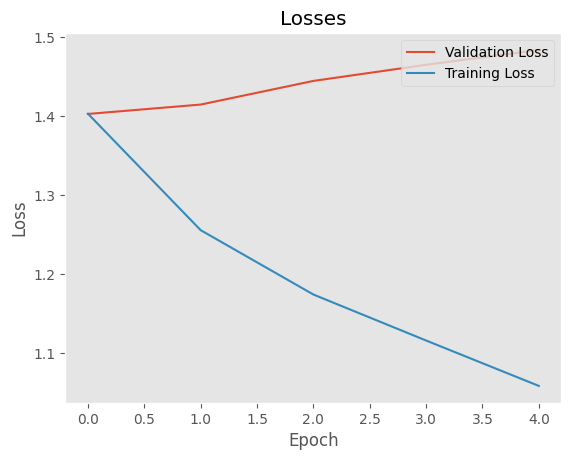

In [15]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
plt.plot(np.arange(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

### Evaluation

#### Quantitative Evaluation: Test Loss and BLEU score

In [16]:
# Quantitative Evaluation
# Load best model
wmt_transformer_model_ft_direct.load_parameters(model_filename_ft_direct)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_ft_direct,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_ft_direct,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 1.28; test bleu score: 27.05


#### Qualitative Evaluation: Translation from English to German Example

In [17]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft_direct,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge jeden Tag.
In English:
I learn new things every day.
The German translation is:
Immer wieder erfährt ich Neues.


## Optimal Data Loading: CPU/GPU Optimization

In [71]:
# Context variable is now a list,
# with each element corresponding to a GPU device
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]
num_gpus = len(ctx_list)

In [72]:
# From strings converted to ND arrays,
# we can continue processing in GPU
# wmt2016_train_data_processed_gpu = mx.gluon.data.SimpleDataset(
#     [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
#      for idx, (data, label) in enumerate(wmt2016_train_data_processed)])

# wmt2016_val_data_processed_gpu = mx.gluon.data.SimpleDataset(
#     [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
#      for idx, (data, label) in enumerate(wmt2016_val_data_processed)])

# wmt2016_test_data_processed_gpu = mx.gluon.data.SimpleDataset(
#     [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
#      for idx, (data, label) in enumerate(wmt2016_test_data_processed)])

# # Pre-processing in CPU to free GPU memory
wmt2016_train_data_processed_gpu = wmt2016_train_data_processed
wmt2016_val_data_processed_gpu = wmt2016_val_data_processed
wmt2016_test_data_processed_gpu = wmt2016_test_data_processed

In [73]:
wmt2016_train_data_len_processed_gpu = wmt2016_train_data_processed_gpu.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)
wmt2016_val_data_len_processed_gpu = wmt2016_val_data_processed_gpu.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed_gpu = wmt2016_test_data_processed_gpu.transform(transformer_model.get_length_index_fn(), lazy=False)

In [74]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_train_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_train_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
#     use_average_length=False,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 16,
    shuffle=True)

wmt2016_val_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
#     use_average_length=False,
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 16,
    shuffle=False)

wmt2016_test_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
#     use_average_length=False,
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 16,
    shuffle=False)

In [75]:
num_workers = 0

wmt2016_train_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_train_data_len_processed_gpu,
    batch_sampler=wmt2016_train_batch_sampler_gpu,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

wmt2016_val_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_val_data_len_processed_gpu,
    batch_sampler=wmt2016_val_batch_sampler_gpu,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_test_data_len_processed_gpu,
    batch_sampler=wmt2016_test_batch_sampler_gpu,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

# wmt2016_train_data_loader_gpu = wmt2016_train_data_loader
# wmt2016_val_data_loader_gpu = wmt2016_val_data_loader
# wmt2016_test_data_loader_gpu = wmt2016_test_data_loader

#### Testing Pre-processing and Data-Loading

In [68]:
start_time = time.time()

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_processed_gpu = mx.gluon.data.SimpleDataset(
    [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
     for idx, (data, label) in enumerate(wmt2016_train_data_processed)])

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed_gpu)

wmt2016_train_data_len_processed_gpu = wmt2016_train_data_processed_gpu.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)

to_cpu_fn = lambda data, label, src_len, tgt_len: (data.as_in_context(mx.cpu()), label.as_in_context(mx.cpu()), src_len, tgt_len)

wmt2016_train_data_len_processed_gpu_cpu = wmt2016_train_data_len_processed_gpu.transform(to_cpu_fn, lazy=False)

print("Pre-processing time (s):", time.time() - start_time)

Pre-processing time (s): 50.427586793899536


In [69]:
start_time = time.time()

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_processed_gpu = mx.gluon.data.SimpleDataset(
    [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
     for idx, (data, label) in enumerate(wmt2016_train_data_processed)])

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed_gpu)

wmt2016_train_data_len_processed_gpu = wmt2016_train_data_processed_gpu.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)

to_cpu_fn = lambda data, label, src_len, tgt_len: (data.as_in_context(mx.cpu()), label.as_in_context(mx.cpu()), src_len, tgt_len)

wmt2016_train_data_len_processed_gpu_cpu = wmt2016_train_data_len_processed_gpu.transform(to_cpu_fn, lazy=False)

wmt2016_train_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_train_data_len_processed_gpu,
    batch_sampler=wmt2016_train_batch_sampler_gpu,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

for idx, (data, label, _, _) in enumerate(tqdm(wmt2016_train_data_loader)):
    data.as_in_context(ctx_list[idx % num_gpus])
    label.as_in_context(ctx_list[idx % num_gpus])

print("Data-Loading in GPU time (s):", time.time() - start_time)

  0%|          | 0/15048 [00:00<?, ?it/s]

Data-Loading in GPU time (s): 72.83465576171875


In [80]:
start_time = time.time()

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)

wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)

wmt2016_train_data_loader = mx.gluon.data.DataLoader(
    wmt2016_train_data_len_processed,
    batch_sampler=wmt2016_train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

for idx, (data, label, _, _) in enumerate(tqdm(wmt2016_train_data_loader)):
    data.as_in_context(ctx_list[idx % num_gpus])
    label.as_in_context(ctx_list[idx % num_gpus])

print("Data-Loading in CPU with Gluon DataLoaders time (s):", time.time() - start_time)

  0%|          | 0/15048 [00:00<?, ?it/s]

Data-Loading in CPU with Gluon DataLoaders time (s): 24.988255500793457


## Optimal Training: Automatic Mixed Precision (AMP) + Multi-GPU

In [76]:
# Context variable is now a list,
# with each element corresponding to a GPU device
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]
num_gpus = len(ctx_list)

In [78]:
# AMP
amp.init()

# Build on top of Pre-Trained model
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_ft_direct_opt, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx_list)

print('Source Vocab:', len(wmt_src_vocab), ', Target Vocab:', len(wmt_tgt_vocab))

# No need to re-configure last layer, just re-initialize
# wmt_transformer_model_ft_direct.tgt_proj.initialize(ctx=ctx_list, force_reinit=True)

wmt_transformer_model_ft_direct_opt.hybridize(static_alloc=True, static_shape=True)

model_filename_ft_direct_opt = "transformer_en_de_512_ft_direct_opt.params"


wmt_translator_ft_direct_opt = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft_direct_opt,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

# Epochs & Batch Size
hparams.epochs = 5
hparams.lr = 0.0001
# hparams.batch_size = 16 * 256
# hparams.lr = 0.00003
hparams.log_interval = 100

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

Source Vocab: 36794 , Target Vocab: 36794


In [79]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft_direct_opt.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

amp.init_trainer(trainer)

start_time = time.time()

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader_gpu)):
           
        src_seq_list = mx.gluon.utils.split_and_load(src_seq, ctx_list=ctx_list, even_split=False)
        tgt_seq_list = mx.gluon.utils.split_and_load(tgt_seq, ctx_list=ctx_list, even_split=False)
        src_valid_length_list = mx.gluon.utils.split_and_load(src_valid_length, ctx_list=ctx_list, even_split=False)
        tgt_valid_length_list = mx.gluon.utils.split_and_load(tgt_valid_length, ctx_list=ctx_list, even_split=False)
        
        losses = []
        
        with mx.autograd.record():
            for src_seq_slice, tgt_seq_slice, src_valid_length_slice, tgt_valid_length_slice in zip(src_seq_list, tgt_seq_list, src_valid_length_list, tgt_valid_length_list):
                
                assert src_seq_slice.context == tgt_seq_slice.context == src_valid_length_slice.context == tgt_valid_length_slice.context                
                
                out_slice, _ = wmt_transformer_model_ft_direct_opt(
                    src_seq_slice,
                    tgt_seq_slice[:, :-1],
                    src_valid_length_slice,
                    tgt_valid_length_slice - 1)
                
                loss = loss_function(out_slice, tgt_seq_slice[:, 1:], tgt_valid_length_slice - 1)
                loss.backward()
                
#                 with amp.scale_loss(loss, trainer) as scaled_loss:
#                     scaled_loss.backward()
                    
                losses.append(loss)
        
        trainer.step(1)
        
        src_wc = 0
        tgt_wc = 0
        
        for loss, tgt_seq_slice, src_valid_length_slice, tgt_valid_length_slice in zip(losses, tgt_seq_list, src_valid_length_list, tgt_valid_length_list):
            
            assert loss.context == tgt_seq_slice.context == src_valid_length_slice.context == tgt_valid_length_slice.context
            
            src_valid_length_slice_cpu = src_valid_length_slice.as_in_context(mx.cpu())
            tgt_valid_length_slice_cpu = tgt_valid_length_slice.as_in_context(mx.cpu())
            
            loss = loss.mean().as_in_context(mx.cpu()) * (tgt_seq_slice.shape[1] - 1)
            log_loss += loss * tgt_seq_slice.shape[0]
            log_denom += (tgt_valid_length_slice_cpu - 1).sum()
            loss = loss / (tgt_valid_length_slice_cpu - 1).mean()
            
            src_wc += src_valid_length_slice_cpu.sum().asscalar()
            tgt_wc += (tgt_valid_length_slice_cpu - 1).sum().asscalar()
        

        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_wc += src_wc + tgt_wc
            
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader_gpu),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 wps / 1000, log_wc / 1000))
            
            log_loss = 0
            log_denom = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader_gpu)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate_multi(
        wmt_transformer_model_ft_direct_opt,
        wmt2016_val_data_loader_gpu,
        loss_function,
        wmt_translator_ft_direct_opt,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx_list=ctx_list)

    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft_direct_opt))
        wmt_transformer_model_ft_direct_opt.save_parameters(model_filename_ft_direct_opt)

print("Training time for 5 epochs:", time.time() - start_time, "/ Best validation loss:", min(wmt2016_valid_losses))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

[17:13:08] /work/mxnet/src/kvstore/././comm.h:741: only 4 out of 12 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[17:13:08] /work/mxnet/src/kvstore/././comm.h:750: .v..
[17:13:08] /work/mxnet/src/kvstore/././comm.h:750: v...
[17:13:08] /work/mxnet/src/kvstore/././comm.h:750: ...v
[17:13:08] /work/mxnet/src/kvstore/././comm.h:750: ..v.


[Epoch 0 Batch 100/806] loss=1.4677, ppl=4.3391, throughput=24.07K wps, wc=704.91K
[Epoch 0 Batch 200/806] loss=1.4442, ppl=4.2386, throughput=12.85K wps, wc=718.76K
[Epoch 0 Batch 300/806] loss=1.4165, ppl=4.1227, throughput=8.61K wps, wc=717.06K
[Epoch 0 Batch 400/806] loss=1.4091, ppl=4.0923, throughput=6.44K wps, wc=712.26K
[Epoch 0 Batch 500/806] loss=1.3886, ppl=4.0094, throughput=5.17K wps, wc=712.52K
[Epoch 0 Batch 600/806] loss=1.3895, ppl=4.0129, throughput=4.30K wps, wc=709.65K
[Epoch 0 Batch 700/806] loss=1.3674, ppl=3.9253, throughput=3.71K wps, wc=711.76K
[Epoch 0 Batch 800/806] loss=1.3892, ppl=4.0114, throughput=3.28K wps, wc=713.76K


  0%|          | 0/14 [00:00<?, ?it/s]

[17:16:47] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[17:16:51] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[17:16:55] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[17:16:59] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.


[Epoch 0] valid Loss=1.2577, valid ppl=3.5173, valid bleu=28.31
Save best parameters to transformer_en_de_512_ft_direct_opt.params


  0%|          | 0/806 [00:00<?, ?it/s]

[Epoch 1 Batch 100/806] loss=1.2779, ppl=3.5890, throughput=25.97K wps, wc=712.34K
[Epoch 1 Batch 200/806] loss=1.3089, ppl=3.7021, throughput=13.18K wps, wc=713.54K
[Epoch 1 Batch 300/806] loss=1.2779, ppl=3.5890, throughput=8.85K wps, wc=714.97K
[Epoch 1 Batch 400/806] loss=1.2754, ppl=3.5802, throughput=6.60K wps, wc=710.28K
[Epoch 1 Batch 500/806] loss=1.2856, ppl=3.6167, throughput=5.21K wps, wc=704.30K
[Epoch 1 Batch 600/806] loss=1.2739, ppl=3.5748, throughput=4.40K wps, wc=713.27K
[Epoch 1 Batch 700/806] loss=1.2888, ppl=3.6283, throughput=3.80K wps, wc=717.55K
[Epoch 1 Batch 800/806] loss=1.2962, ppl=3.6553, throughput=3.31K wps, wc=714.58K


  0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 1] valid Loss=1.2200, valid ppl=3.3871, valid bleu=27.15


  0%|          | 0/806 [00:00<?, ?it/s]

[Epoch 2 Batch 100/806] loss=1.2055, ppl=3.3386, throughput=25.54K wps, wc=704.26K
[Epoch 2 Batch 200/806] loss=1.2026, ppl=3.3287, throughput=13.24K wps, wc=714.86K
[Epoch 2 Batch 300/806] loss=1.1976, ppl=3.3120, throughput=8.91K wps, wc=717.93K
[Epoch 2 Batch 400/806] loss=1.2128, ppl=3.3630, throughput=6.58K wps, wc=708.12K
[Epoch 2 Batch 500/806] loss=1.1894, ppl=3.2851, throughput=5.31K wps, wc=715.40K
[Epoch 2 Batch 600/806] loss=1.2247, ppl=3.4032, throughput=4.42K wps, wc=711.32K
[Epoch 2 Batch 700/806] loss=1.2196, ppl=3.3857, throughput=3.83K wps, wc=716.75K
[Epoch 2 Batch 800/806] loss=1.2060, ppl=3.3400, throughput=3.34K wps, wc=715.43K


  0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 2] valid Loss=1.2261, valid ppl=3.4078, valid bleu=27.30


  0%|          | 0/806 [00:00<?, ?it/s]

[Epoch 3 Batch 100/806] loss=1.1408, ppl=3.1291, throughput=24.80K wps, wc=713.75K
[Epoch 3 Batch 200/806] loss=1.1504, ppl=3.1593, throughput=12.80K wps, wc=711.63K
[Epoch 3 Batch 300/806] loss=1.1307, ppl=3.0978, throughput=8.56K wps, wc=711.19K
[Epoch 3 Batch 400/806] loss=1.1728, ppl=3.2311, throughput=6.55K wps, wc=717.84K
[Epoch 3 Batch 500/806] loss=1.1604, ppl=3.1911, throughput=5.22K wps, wc=711.71K
[Epoch 3 Batch 600/806] loss=1.1378, ppl=3.1199, throughput=4.36K wps, wc=711.19K
[Epoch 3 Batch 700/806] loss=1.1639, ppl=3.2024, throughput=3.78K wps, wc=717.22K
[Epoch 3 Batch 800/806] loss=1.1314, ppl=3.1000, throughput=3.26K wps, wc=706.79K


  0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 3] valid Loss=1.2531, valid ppl=3.5012, valid bleu=26.06


  0%|          | 0/806 [00:00<?, ?it/s]

[Epoch 4 Batch 100/806] loss=1.0833, ppl=2.9545, throughput=25.75K wps, wc=715.33K
[Epoch 4 Batch 200/806] loss=1.0873, ppl=2.9662, throughput=13.06K wps, wc=717.68K
[Epoch 4 Batch 300/806] loss=1.1041, ppl=3.0166, throughput=8.79K wps, wc=716.74K
[Epoch 4 Batch 400/806] loss=1.0872, ppl=2.9661, throughput=6.48K wps, wc=702.89K
[Epoch 4 Batch 500/806] loss=1.1097, ppl=3.0334, throughput=5.19K wps, wc=704.50K
[Epoch 4 Batch 600/806] loss=1.1045, ppl=3.0176, throughput=4.42K wps, wc=715.83K
[Epoch 4 Batch 700/806] loss=1.0966, ppl=2.9939, throughput=3.78K wps, wc=715.56K
[Epoch 4 Batch 800/806] loss=1.1251, ppl=3.0804, throughput=3.31K wps, wc=712.20K


  0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 4] valid Loss=1.2717, valid ppl=3.5668, valid bleu=25.79
Training time for 5 epochs: 1947.1244320869446 / Best validation loss: 1.2199710432327155


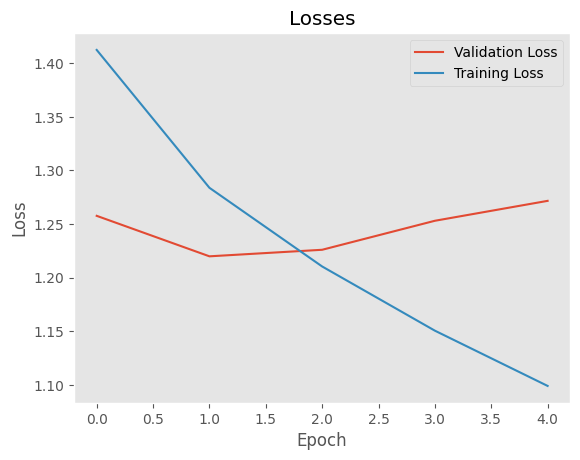

In [81]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
plt.plot(np.arange(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

### Evaluation

#### Quantitative Evaluation: Test Loss and BLEU score

In [82]:
# Quantitative Evaluation
# Load best model
wmt_transformer_model_ft_direct_opt.load_parameters(model_filename_ft_direct_opt)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate_multi(
    wmt_transformer_model_ft_direct_opt,
    wmt2016_test_data_loader_gpu,
    loss_function,
    wmt_translator_ft_direct_opt,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/13 [00:00<?, ?it/s]

WMT16 test loss: 1.27; test bleu score: 27.89


#### Qualitative Evaluation: Translation from English to German Example

In [83]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft_direct_opt,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne jedes Mal Neues.
